In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim 
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import time 
import pickle

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
torch.cuda.is_available()

True

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Test Loader:   0%|          | 0/94 [02:23<?, ?it/s]


In [14]:
def load_saved_data_loaders(file_path):
    with open(file_path, 'rb') as f:
        train_loader, val_loader, test_loader = pickle.load(f)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_saved_data_loaders("data_loaders.pkl")

In [15]:
def class_to_one_hot(class_indices, num_classes):
    return torch.eye(num_classes)[class_indices]

In [52]:
import torch
import torch.nn as nn

class IdentityNorm(nn.Module):
    def __init__(self,num_features, affine=True):
        super(IdentityNorm, self).__init__()
        shape = (1, self.num_features, 1, 1)
        
        if self.affine:
            self.gamma = nn.Parameter(torch.empty(shape))
            self.beta = nn.Parameter(torch.empty(shape))
            
        self._param_init()

    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    def forward(self, x):
        return x


class StandardBatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
        super(StandardBatchNorm, self).__init__()
        self.momentum = momentum
        self.running_mean = 0
        self.running_var = 0
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.affine = affine
        shape = (1, self.num_features, 1, 1)

        if self.affine:
            self.gamma = nn.Parameter(torch.empty(shape))
            self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()

    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    def forward(self, x):
        if self.training:
            n = x.numel() / x.size(1)
            dimensions = (0, 2, 3)
            var = x.var(dim=dimensions, keepdim=True, unbiased=False)
            mean = x.mean(dim=dimensions, keepdim=True)

            with torch.no_grad():
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * (n / (n - 1)) * var + (1 - self.momentum) * self.running_var

        else:
            mean = self.running_mean
            var = self.running_var
        dn = torch.sqrt(var + self.eps)
        x = (x - mean) / dn
        if self.affine:
            x = x * self.gamma + self.beta

        return x


class InstanceNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
        super(InstanceNorm, self).__init__()
        self.momentum = momentum
        self.running_mean = 0
        self.running_var = 0
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.affine = affine
        shape = (1, self.num_features, 1, 1)

        if self.affine:
            self.gamma = nn.Parameter(torch.empty(shape))
            self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()


    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)


    def forward(self, x):
        N, C, H, W = x.shape

        assert C == self.num_features
        # print(x.shape)
        # x = x.view(N, self.num_features, -1)
        # print(x.shape, "\n")
        dimensions = (2,3)
        if self.training:
            mean = x.mean(dim=dimensions, keepdim=True)
            var = x.var(dim=dimensions, keepdim=True)
            # print(mean.shape, var.shape)
            # with torch.no_grad():
                
            #     self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
            #     self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var

        else:
            # mean = self.running_mean
            # var = self.running_var            
            mean = x.mean(dim=dimensions, keepdim=True)
            var = x.var(dim=dimensions, keepdim=True)
        dn = torch.sqrt(var + self.eps)
        x = (x - mean)/ dn

        # x = x.view(N, C, H, W)

        if self.affine:
            x = x * self.gamma + self.beta

        return x


class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
        super(LayerNorm, self).__init__()
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.affine = affine
        shape = (1, self.num_features, 1, 1)

        if self.affine:
            self.gamma = nn.Parameter(torch.empty(shape))
            self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()


    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    def forward(self, x):
        
        N, C, H, W = x.shape

        assert C == self.num_features
        dimensions = (1,2,3)
        if self.training:
            mean = x.mean(dim=dimensions, keepdim=True)            
            var = x.var(dim=dimensions, keepdim=True)
        else:
            mean = x.mean(dim=dimensions, keepdim=True)            
            var = x.var(dim=dimensions, keepdim=True)
        dn = torch.sqrt(var + self.eps)
        x = (x - mean)/ dn

        if self.affine:
            x = x * self.gamma + self.beta

        return x



class GroupNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, group=4, affine=True):
        super(GroupNorm,self).__init__()
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.affine = affine
        self.group = group        
        shape = (1, self.num_features, 1, 1)

        if self.affine:
            self.gamma = nn.Parameter(torch.empty(shape))
            self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()


    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    def forward(self, x):
        N, C, H, W = x.shape

        assert C % self.group == 0
        assert self.num_features == C

        x = x.view(N, self.group, int(C / self.group), H, W)
        dimensions = (1,2,3)
        mean = x.mean(dim=dimensions, keepdim=True)
        var = x.var(dim=dimensions, keepdim=True)
        dn = torch.sqrt(var + self.eps)
        x = (x - mean)/ dn
        x = x.view(N, C, H, W)
        
        if self.affine:
            x = x * self.gamma + self.beta

        return x

class BatchInstanceNorm(nn.Module):
    def __init__(self, num_features, momentum = 0.1, eps=1e-5, rho=0.5, affine=True):
        super(BatchInstanceNorm, self).__init__()
        self.momentum = momentum
        self.running_mean = 0
        self.running_var = 0
        self.eps = torch.tensor(eps)
        self.num_features = num_features
        self.affine = affine
        self.rho = rho
        shape = (1, self.num_features, 1, 1)

        if self.affine:
            self.gamma = nn.Parameter(torch.empty(shape))
            self.beta = nn.Parameter(torch.empty(shape))

        self._param_init()


    def _param_init(self):
        nn.init.zeros_(self.beta)
        nn.init.ones_(self.gamma)

    
    def forward(self, x):
        if self.training:            
                
            n = x.numel() / x.size(1)
            dimensions = (0,2,3)
            var_bn = x.var(dim=dimensions, keepdim=True, unbiased=False)
            mean_bn = x.mean(dim=dimensions, keepdim=True)

            with torch.no_grad():
                
                self.running_mean = self.momentum * mean_bn + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * (n/(n-1)) * var_bn + (1 - self.momentum) * self.running_var

        else:
            mean_bn = self.running_mean
            var_bn = self.running_var
        dn = torch.sqrt(var_bn + self.eps)
        x_bn = (x - mean_bn)/ dn
        dimensions = (2,3)
        mean_in = x.mean(dim=dimensions, keepdim=True)
        var_in = x.var(dim=dimensions, keepdim=True)
        dn = torch.sqrt(var_in + self.eps)
        x_in = (x - mean_in)/ dn

        x = self.rho * x_bn + (1-self.rho) * x_in

        if self.affine:
            x = x * self.gamma + self.beta

        return x

In [53]:
class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1, norm_type='batch'):
        super().__init__()
        self.expansion = 2
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        
        if norm_type == 'bn':
            self.nl1 = StandardBatchNorm(intermediate_channels)
            self.nl2 = StandardBatchNorm(intermediate_channels* self.expansion)
        elif norm_type == 'in':
            self.nl1 = InstanceNorm(intermediate_channels)
            self.nl2 = InstanceNorm(intermediate_channels* self.expansion)
        elif norm_type == 'gn':
            self.nl1 = GroupNorm(4, intermediate_channels)  # Assuming a group size of 4
            self.nl2 = GroupNorm(4, intermediate_channels* self.expansion)
        elif norm_type == 'bin':
            self.nl1 = BatchInstanceNorm(intermediate_channels)
            self.nl2 = BatchInstanceNorm(intermediate_channels* self.expansion)
        elif norm_type == 'ln':
            self.nl1 = LayerNorm(intermediate_channels)
            self.nl2 = LayerNorm(intermediate_channels* self.expansion)
        elif norm_type=='nn':
            self.nl1= IdentityNorm(intermediate_channels)
            self.nl2 = IdentityNorm(intermediate_channels* self.expansion)
            
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=3, stride=1, padding=1, bias=False)    
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.nl1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.nl2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x



class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes, norm_type='bn'):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(image_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)

        if norm_type == 'bn':
            self.norm = StandardBatchNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type == 'in':
            self.norm = InstanceNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type == 'gn':
            self.norm = GroupNorm(4, 16)  # Assuming a group size of 4
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type == 'bin':
            self.norm = BatchInstanceNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type == 'ln':
            self.norm = LayerNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
            
        elif norm_type=='nn':
            self.norm= IdentityNorm(16)
            self.gamma = self.norm.gamma
            self.beta = self.norm.beta
        else:
            raise ValueError("Invalid normalization type. Choose from 'batch', 'instance', or 'group'.")
        self.relu = nn.ReLU()
        
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=16, stride=1, norm_type=norm_type)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=32, stride=2, norm_type=norm_type)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=64, stride=2, norm_type=norm_type)
        
        self.avgpool = nn.AdaptiveAvgPool2d((8,8))
        self.fc = nn.Linear(128 * 8*8, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x
    
    
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride, norm_type):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 2:
            if norm_type == 'gn':
                num_groups = 4  # Adjust according to your group size preference
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    GroupNorm(num_groups, intermediate_channels * 2),
                )
            elif norm_type == 'bn':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    StandardBatchNorm(intermediate_channels * 2)
                )
            elif norm_type == 'in':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    InstanceNorm(intermediate_channels * 2)
                )
            elif norm_type == 'bin':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    BatchInstanceNorm(intermediate_channels * 2)
                )
            elif norm_type == 'ln':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    LayerNorm(intermediate_channels * 2)
                )
            elif norm_type == 'idn':
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    IdentityNorm(intermediate_channels * 2)
                )
            else:
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, intermediate_channels * 2, kernel_size=1, stride=stride, bias=False),
                    StandardBatchNorm(intermediate_channels * 2)
                )

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride, norm_type))
        self.in_channels = intermediate_channels * 2

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels, norm_type=norm_type))

        return nn.Sequential(*layers)






def ResNet101(img_channel=3, num_classes=25, norm_type='bn'):
    return ResNet(Block, [2,2,2], img_channel, num_classes, norm_type)


In [35]:
train_loader, val_loader, test_loader = load_saved_data_loaders("data_loaders.pkl")

In [54]:
BATCH_SIZE= 32
model = ResNet101(img_channel=3, norm_type='in',num_classes=25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [55]:
# Print all parameters
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

Parameter name: gamma, Shape: torch.Size([1, 16, 1, 1])
Parameter name: beta, Shape: torch.Size([1, 16, 1, 1])
Parameter name: conv1.weight, Shape: torch.Size([16, 3, 3, 3])
Parameter name: layer1.0.conv1.weight, Shape: torch.Size([16, 16, 3, 3])
Parameter name: layer1.0.nl1.gamma, Shape: torch.Size([1, 16, 1, 1])
Parameter name: layer1.0.nl1.beta, Shape: torch.Size([1, 16, 1, 1])
Parameter name: layer1.0.nl2.gamma, Shape: torch.Size([1, 32, 1, 1])
Parameter name: layer1.0.nl2.beta, Shape: torch.Size([1, 32, 1, 1])
Parameter name: layer1.0.conv2.weight, Shape: torch.Size([32, 16, 3, 3])
Parameter name: layer1.0.identity_downsample.0.weight, Shape: torch.Size([32, 16, 1, 1])
Parameter name: layer1.0.identity_downsample.1.gamma, Shape: torch.Size([1, 32, 1, 1])
Parameter name: layer1.0.identity_downsample.1.beta, Shape: torch.Size([1, 32, 1, 1])
Parameter name: layer1.1.conv1.weight, Shape: torch.Size([16, 32, 3, 3])
Parameter name: layer1.1.nl1.gamma, Shape: torch.Size([1, 16, 1, 1])
Pa

In [41]:
# if torch.cuda.device_count() > 1:
print("Using", torch.cuda.device_count(), "GPUs!")
    # model = nn.DataParallel(model)

Using 1 GPUs!


In [42]:
# def train(num_epochs=50, batch_size=32, )

In [43]:

# Set the number of epochs
num_epochs = 2
train_losses = []
train_accuracies = []
train_micro_f1_scores = []
train_macro_f1_scores = []
val_losses = []
val_accuracies = []
val_micro_f1_scores = []
val_macro_f1_scores = []

# Early stopping parameters
patience = 2
early_stopping_counter = 0
best_val_loss = np.inf

# Training loop
total_start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    all_labels = []
    all_predictions = []

    # Training
    for data, labels in tqdm(train_loader, desc=f'Training - Epoch {epoch + 1}/{num_epochs}', leave=False):
        x = data.to(device)
        y = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        y_hat = model(x)

        # Compute the loss
        loss = criterion(y_hat, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Record predictions for calculating metrics
        all_labels.extend(y.cpu().numpy())
        all_predictions.extend(torch.argmax(y_hat, dim=1).cpu().numpy())

    epoch_train_time = time.time() - epoch_start_time

    average_loss = running_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    micro_f1 = f1_score(all_labels, all_predictions, average='micro')
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Train - Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}, Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}, Time: {epoch_train_time:.2f} seconds")

    train_losses.append(average_loss)
    train_accuracies.append(accuracy)
    train_micro_f1_scores.append(micro_f1)
    train_macro_f1_scores.append(macro_f1)

    # Validation
    epoch_val_start_time = time.time()
    model.eval()
    val_running_loss = 0
    val_all_labels = []
    val_all_predictions = []

    with torch.no_grad():
        for val_data, val_labels in tqdm(val_loader, desc=f'Validation - Epoch {epoch + 1}/{num_epochs}', leave=False):
            val_x = val_data.to(device)
            val_y = val_labels.to(device)

            val_y_hat = model(val_x)
            val_loss = criterion(val_y_hat, val_y)

            val_running_loss += val_loss.item()

            val_all_labels.extend(val_y.cpu().numpy())
            val_all_predictions.extend(torch.argmax(val_y_hat, dim=1).cpu().numpy())

    epoch_val_time = time.time() - epoch_val_start_time
    val_average_loss = val_running_loss / len(val_loader)
    val_accuracy = accuracy_score(val_all_labels, val_all_predictions)
    val_micro_f1 = f1_score(val_all_labels, val_all_predictions, average='micro')
    val_macro_f1 = f1_score(val_all_labels, val_all_predictions, average='macro')

    print(f"Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_average_loss:.4f}, Accuracy: {val_accuracy:.4f}, Micro F1: {val_micro_f1:.4f}, Macro F1: {val_macro_f1:.4f}, Time: {epoch_val_time:.2f} seconds")

    val_losses.append(val_average_loss)
    val_accuracies.append(val_accuracy)
    val_micro_f1_scores.append(val_micro_f1)
    val_macro_f1_scores.append(val_macro_f1)

    # Check for early stopping
    if val_average_loss < best_val_loss:
        best_val_loss = val_average_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs without improvement.")
        break  # Stop training
    


    # Save model checkpoint only if there's an improvement in validation loss
    # if val_average_loss < best_val_loss:
        
        # torch.save({
        #     'epoch': epoch,
        #     'model_state_dict': model.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'micro_f1': train_micro_f1_scores,
        #     'macro_f1': train_macro_f1_scores,
        #     'accuracies': train_accuracies,
        #     'val_micro_f1': val_micro_f1_scores,
        #     'val_macro_f1': val_macro_f1_scores,
        #     'val_accuracies': val_accuracies,
        #     # Add other necessary information
        # }, 'saved_stuff/best_model2.pth')
        # print(f"Saved best model checkpoint for Epoch: {epoch + 1}")
        
    torch.save(model.state_dict(), 'simple_model.pth')
    print("Saved Model !!")

# Total training timeaut
total_train_time = time.time() - total_start_time
print(f"Total Training Time: {total_train_time / 60:.2f} minutes")


Train - Epoch [1/2], Loss: 0.8453, Accuracy: 0.6250, Micro F1: 0.6250, Macro F1: 0.2108, Time: 108.17 seconds


Validation - Epoch [1/2], Loss: 0.5561, Accuracy: 0.7445, Micro F1: 0.7445, Macro F1: 0.7445, Time: 31.22 seconds
Saved Model !!


Train - Epoch [2/2], Loss: 0.4812, Accuracy: 0.7817, Micro F1: 0.7817, Macro F1: 0.7816, Time: 100.57 seconds


Validation - Epoch [2/2], Loss: 0.4928, Accuracy: 0.7829, Micro F1: 0.7829, Macro F1: 0.7828, Time: 35.80 seconds
Saved Model !!
Total Training Time: 4.60 minutes


In [44]:
m2= ResNet101(img_channel=3, norm_type='in',num_classes=25).to(device)

In [45]:
m2.load_state_dict(torch.load('simple_model.pth'))

<All keys matched successfully>

In [27]:
# Assuming you have a test_loader for your test dataset

model.eval()  # Set the model to evaluation mode

all_test_labels = []
all_predictions = []

with torch.no_grad():
    for test_data, test_labels in tqdm(test_loader, desc='Inference on Test Set', leave=False):
        test_x = test_data.to(device)
        test_y = test_labels.to(device)

        # Forward pass
        test_y_hat = model(test_x)

        # Record predictions for comparison
        all_test_labels.extend(test_y.cpu().numpy())
        all_predictions.extend(torch.argmax(test_y_hat, dim=1).cpu().numpy())

# Convert the labels and predictions to numpy arrays
all_test_labels = np.array(all_test_labels)
all_predictions = np.array(all_predictions)

# Display actual and predicted values
for i in range(len(all_test_labels)):
    if i%100==0:
        print(f"Sample {i + 1}: Actual - {all_test_labels[i]}, Predicted - {all_predictions[i]}")

Sample 1: Actual - 0, Predicted - 3
Sample 101: Actual - 0, Predicted - 0
Sample 201: Actual - 0, Predicted - 0
Sample 301: Actual - 1, Predicted - 1
Sample 401: Actual - 1, Predicted - 2
Sample 501: Actual - 1, Predicted - 4
Sample 601: Actual - 2, Predicted - 2
Sample 701: Actual - 2, Predicted - 2
Sample 801: Actual - 2, Predicted - 2
Sample 901: Actual - 3, Predicted - 3
Sample 1001: Actual - 3, Predicted - 2
Sample 1101: Actual - 3, Predicted - 3
Sample 1201: Actual - 4, Predicted - 4
Sample 1301: Actual - 4, Predicted - 4
Sample 1401: Actual - 4, Predicted - 1


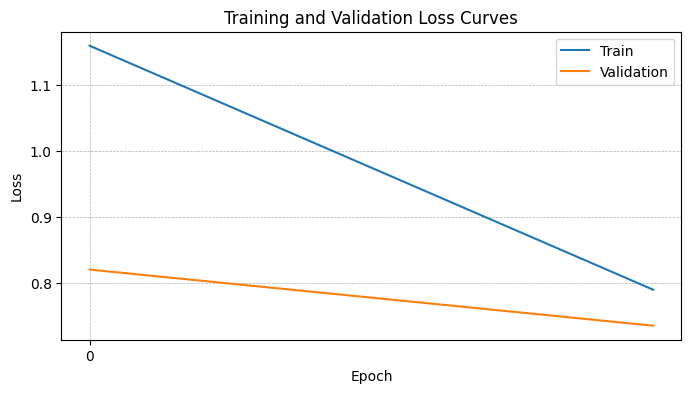

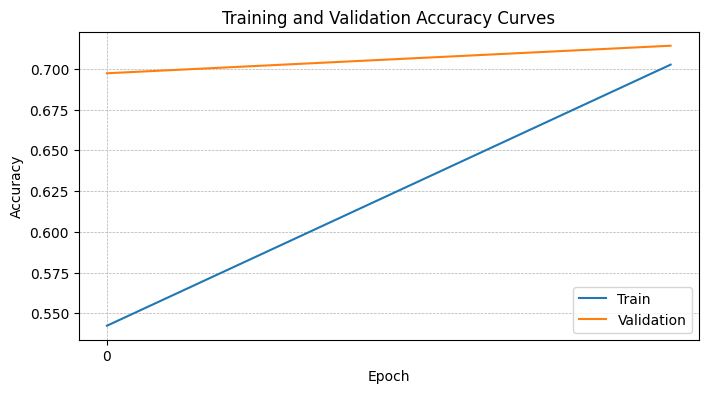

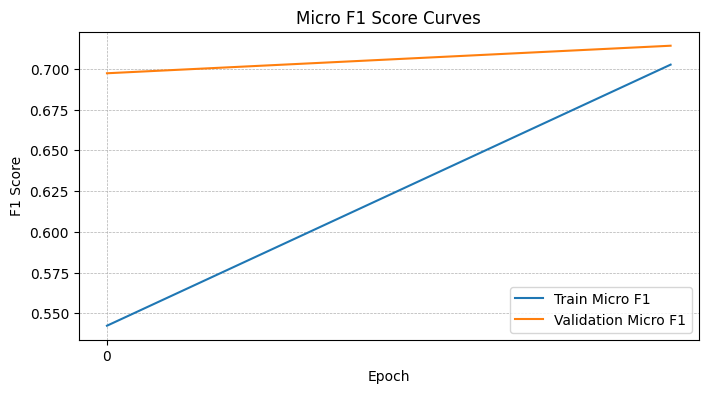

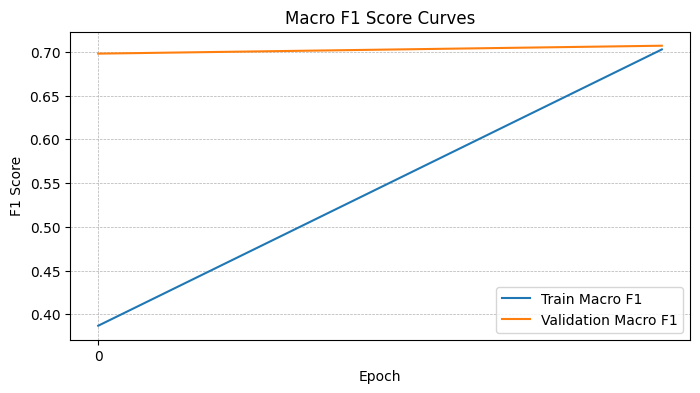

In [28]:

# Function to plot and add gridlines
def plot_with_grid(x, train_data, val_data, train_label, val_label, xlabel, ylabel, title, x_interval=5):
    plt.figure(figsize=(8, 4))
    plt.plot(x, train_data, label=train_label)
    plt.plot(x, val_data, label=val_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.xticks(np.arange(min(x), max(x)+1, x_interval))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Training Loss
plot_with_grid(range(len(train_losses)), train_losses, val_losses, 'Train', 'Validation', 'Epoch', 'Loss', 'Training and Validation Loss Curves')

# Training Accuracy
plot_with_grid(range(len(train_accuracies)), train_accuracies, val_accuracies, 'Train', 'Validation', 'Epoch', 'Accuracy', 'Training and Validation Accuracy Curves')

# Micro F1 Scores
plot_with_grid(range(len(train_micro_f1_scores)), train_micro_f1_scores, val_micro_f1_scores, 'Train Micro F1', 'Validation Micro F1', 'Epoch', 'F1 Score', 'Micro F1 Score Curves')

# Macro F1 Scores
plot_with_grid(range(len(train_macro_f1_scores)), train_macro_f1_scores, val_macro_f1_scores, 'Train Macro F1', 'Validation Macro F1', 'Epoch', 'F1 Score', 'Macro F1 Score Curves')


In [29]:
# import torch
# import torch.nn as nn


# class NoNorm(nn.Module):
#     def __init__(self):
#         super(NoNorm, self).__init__()

#     def forward(self, x):
#         return x


# class BatchNorm(nn.Module):
#     def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
#         super(BatchNorm, self).__init__()
#         self.momentum = momentum
#         self.running_mean = torch.zeros(num_features)
#         self.running_var = torch.ones(num_features)
#         self.eps = eps
#         self.num_features = num_features
#         self.affine = affine

#         if self.affine:
#             self.gamma = nn.Parameter(torch.ones(num_features))
#             self.beta = nn.Parameter(torch.zeros(num_features))

#     def forward(self, x):
#         if self.training:
#             dimensions = (0, 2, 3)
#             var = x.var(dim=dimensions, unbiased=False)
#             mean = x.mean(dim=dimensions)

#             with torch.no_grad():
#                 self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
#                 self.running_var = self.momentum * (x.numel() / x.size(1) / (x.numel() / x.size(1) - 1)) * var + (1 - self.momentum) * self.running_var

#         else:
#             mean = self.running_mean
#             var = self.running_var

#         dn = torch.sqrt(var + self.eps)
#         x = (x - mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)) / dn.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

#         if self.affine:
#             x = x * self.gamma.unsqueeze(0).unsqueeze(-1).unsqueeze(-1) + self.beta.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

#         return x



# class InstanceNorm(nn.Module):
#     def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
#         super(InstanceNorm, self).__init__()
#         self.momentum = momentum
#         self.eps = eps
#         self.num_features = num_features
#         self.affine = affine

#         if self.affine:
#             self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
#             self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

#     def _param_init(self):
#         if self.affine:
#             nn.init.ones_(self.gamma)
#             nn.init.zeros_(self.beta)

#     def forward(self, x):
#         N, C, _, _ = x.shape
#         assert C == self.num_features

#         dimensions = (2, 3)
#         mean = x.mean(dim=dimensions, keepdim=True)
#         var = x.var(dim=dimensions, keepdim=True)

#         dn = torch.sqrt(var + self.eps)
#         x = (x - mean) / dn

#         if self.affine:
#             x = x * self.gamma + self.beta

#         return x


# class LayerNorm(nn.Module):
#     def __init__(self, num_features, eps=1e-5, affine=True):
#         super(LayerNorm, self).__init__()
#         self.eps = eps
#         self.num_features = num_features
#         self.affine = affine

#         if self.affine:
#             self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
#             self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

#     def _param_init(self):
#         if self.affine:
#             nn.init.ones_(self.gamma)
#             nn.init.zeros_(self.beta)

#     def forward(self, x):
#         N, C, H, W = x.shape
#         assert C == self.num_features

#         dimensions = (1, 2, 3)
#         mean = x.mean(dim=dimensions, keepdim=True)
#         var = x.var(dim=dimensions, keepdim=True)

#         dn = torch.sqrt(var + self.eps)
#         x = (x - mean) / dn

#         if self.affine:
#             x = x * self.gamma + self.beta

#         return x



# class GroupNorm(nn.Module):
#     def __init__(self, num_features, eps=1e-5, group=4, affine=True):
#         super(GroupNorm, self).__init__()
#         self.eps = eps
#         self.num_features = num_features
#         self.affine = affine
#         self.group = group

#         if self.affine:
#             self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
#             self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

#     def _param_init(self):
#         if self.affine:
#             nn.init.ones_(self.gamma)
#             nn.init.zeros_(self.beta)

#     def forward(self, x):
#         N, C, H, W = x.shape
#         assert C % self.group == 0
#         assert self.num_features == C

#         x = x.view(N, self.group, C // self.group, H, W)
#         dimensions = (1, 2, 3)
#         mean = x.mean(dim=dimensions, keepdim=True)
#         var = x.var(dim=dimensions, keepdim=True)
#         dn = torch.sqrt(var + self.eps)
#         x = (x - mean) / dn
#         x = x.view(N, C, H, W)

#         if self.affine:
#             x = x * self.gamma + self.beta

#         return x

# class BatchInstanceNorm(nn.Module):
#     def __init__(self, num_features, momentum=0.1, eps=1e-5, rho=0.5, affine=True):
#         super(BatchInstanceNorm, self).__init__()
#         self.momentum = momentum
#         self.eps = eps
#         self.num_features = num_features
#         self.affine = affine
#         self.rho = rho

#         if self.affine:
#             self.gamma = nn.Parameter(torch.ones(1, num_features, 1, 1))
#             self.beta = nn.Parameter(torch.zeros(1, num_features, 1, 1))

#     def _param_init(self):
#         if self.affine:
#             nn.init.ones_(self.gamma)
#             nn.init.zeros_(self.beta)

#     def forward(self, x):
#         dimensions_bn = (0, 2, 3)
#         dimensions_in = (2, 3)

#         if self.training:
#             mean_bn = x.mean(dim=dimensions_bn, keepdim=True)
#             var_bn = x.var(dim=dimensions_bn, keepdim=True, unbiased=False)

#             n = x.numel() / x.size(1)
#             with torch.no_grad():
#                 self.running_mean = self.momentum * mean_bn + (1 - self.momentum) * self.running_mean
#                 self.running_var = self.momentum * (n / (n - 1)) * var_bn + (1 - self.momentum) * self.running_var
#         else:
#             mean_bn = self.running_mean
#             var_bn = self.running_var

#         mean_in = x.mean(dim=dimensions_in, keepdim=True)
#         var_in = x.var(dim=dimensions_in, keepdim=True)

#         dn_bn = torch.sqrt(var_bn + self.eps)
#         x_bn = (x - mean_bn) / dn_bn

#         dn_in = torch.sqrt(var_in + self.eps)
#         x_in = (x - mean_in) / dn_in

#         x = self.rho * x_bn + (1 - self.rho) * x_in

#         if self.affine:
#             x = x * self.gamma + self.beta

#         return x





In [13]:
# ip= torch.rand([3,2,2,2])

# print(f"Input [all dim] : \n{ip}")
# print(f"Input is dim1:\n {ip[0]}")
# print(f"Input is dim2:\n {ip[0][0]}")
# print(f"Input is dim3:\n {ip[0][0][0]}")
# print(f"Input is dim4:\n {ip[0][0][0][0]}")

In [14]:

# # Set the number of epochs

# def trainAndValidateModel(num_epochs=25, normalization_type="BN", opt= "Adam",batch_size= 32):
#     if opt=="Adam":
#         optimizer = optim.Adam(model.parameters(), lr=1e-4)
#     elif opt=="SGD":
#         optimizer = optim.SGD(model.parameters(), lr=1e-4)
#     num_epochs = 25
#     train_losses = []
#     train_accuracies = []
#     train_micro_f1_scores = []
#     train_macro_f1_scores = []
#     val_losses = []
#     val_accuracies = []
#     val_micro_f1_scores = []
#     val_macro_f1_scores = []

#     # Training loop
#     total_start_time = time.time()
#     for epoch in range(num_epochs):
#         epoch_start_time = time.time()
#         model.train()
#         running_loss = 0
#         all_labels = []
#         all_predictions = []

#         # Training
#         for data, labels in tqdm(train_loader, desc=f'Training - Epoch {epoch + 1}/{num_epochs}', leave=False):
#             x = data.to(device)
#             y = labels.to(device)

#             optimizer.zero_grad()

#             # Forward pass
#             y_hat = model(x)

#             # Compute the loss
#             loss = criterion(y_hat, y)

#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#             # Record predictions for calculating metrics
#             all_labels.extend(y.cpu().numpy())
#             all_predictions.extend(torch.argmax(y_hat, dim=1).cpu().numpy())

#         epoch_train_time = time.time() - epoch_start_time

#         average_loss = running_loss / len(train_loader)
#         accuracy = accuracy_score(all_labels, all_predictions)
#         micro_f1 = f1_score(all_labels, all_predictions, average='micro')
#         macro_f1 = f1_score(all_labels, all_predictions, average='macro')

#         print(f"Train - Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}, Micro F1: {micro_f1:.4f}, Macro F1: {macro_f1:.4f}, Time: {epoch_train_time:.2f} seconds")

#         train_losses.append(average_loss)
#         train_accuracies.append(accuracy)
#         train_micro_f1_scores.append(micro_f1)
#         train_macro_f1_scores.append(macro_f1)

#         # Validation
#         model.eval()
#         val_running_loss = 0
#         val_all_labels = []
#         val_all_predictions = []

#         with torch.no_grad():
#             for val_data, val_labels in tqdm(val_loader, desc=f'Validation - Epoch {epoch + 1}/{num_epochs}', leave=False):
#                 val_x = val_data.to(device)
#                 val_y = val_labels.to(device)

#                 val_y_hat = model(val_x)
#                 val_loss = criterion(val_y_hat, val_y)

#                 val_running_loss += val_loss.item()

#                 val_all_labels.extend(val_y.cpu().numpy())
#                 val_all_predictions.extend(torch.argmax(val_y_hat, dim=1).cpu().numpy())

#         val_average_loss = val_running_loss / len(val_loader)
#         val_accuracy = accuracy_score(val_all_labels, val_all_predictions)
#         val_micro_f1 = f1_score(val_all_labels, val_all_predictions, average='micro')
#         val_macro_f1 = f1_score(val_all_labels, val_all_predictions, average='macro')

#         print(f"Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_average_loss:.4f}, Accuracy: {val_accuracy:.4f}, Micro F1: {val_micro_f1:.4f}, Macro F1: {val_macro_f1:.4f}")

#         val_losses.append(val_average_loss)
#         val_accuracies.append(val_accuracy)
#         val_micro_f1_scores.append(val_micro_f1)
#         val_macro_f1_scores.append(val_macro_f1)

#         # Save model checkpoint if needed
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'micro_f1': train_micro_f1_scores,
#             'macro_f1': train_macro_f1_scores,
#             'accuracies': train_accuracies,
#             'val_micro_f1': val_micro_f1_scores,
#             'val_macro_f1': val_macro_f1_scores,
#             'val_accuracies': val_accuracies,
#             # Add other necessary information
#         }, 'saved_stuff/model.pth')
#         print(f".... Saved for Epoch: {epoch}")

#     # Total training time
#     total_train_time = time.time() - total_start_time
#     print(f"Total Training Time: {total_train_time / 60:.2f} minutes")

#     # Validation time
#     total_val_time = time.time() - total_start_time

#     print(f"Total Validation Time: {total_val_time / 60:.2f} minutes")
    
# #         train_losses = []
# #     train_accuracies = []
# #     train_micro_f1_scores = []
# #     train_macro_f1_scores = []
# #     val_losses = []
# #     val_accuracies = []
# #     val_micro_f1_scores = []
# #     val_macro_f1_scores = []

# return train_losses, train_accuracies, train_micro_f1_scores, train_macro_f1_scores, val_losses,val_accuracies,val_micro_f1_scores, val_macro_f1_scores

